# mmFace Liveness Classification
## Dataset Building and Loading

In [1]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from utils import by_experiment, get_crd_data
from dataset_builder import GenericDataset
from glob import glob
from tqdm import tqdm
import torch
import json
import os
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def auxillary_build(data_path, subjects, train, val, test, train_split, test_split, num_frames, real=True):
    val_split_end = train_split + test_split
    for i, subject in enumerate(tqdm(subjects)):
        radar_paths = sorted(glob(rf"{data_path}\{subject}\*_radar.json"), key=by_experiment)
        for rp in radar_paths:
            with open(rp, 'r') as f:
                exp_ard = np.abs(get_crd_data(json.load(f), num_chirps_per_burst=16))[:num_frames].astype(np.float32)
                shuffled = np.random.permutation(len(exp_ard))
                exp_ard = exp_ard[shuffled]
                
                # Take 15 frames per experiment to evenly distribute 225 total frames per paper subject
                n = 15 if real else len(exp_ard)
                if len(train) <= i:
                    train.append([exp_ard[:int(n*train_split)]])
                    val.append([exp_ard[int(n*train_split):int(n*val_split_end)]])
                    test.append([exp_ard[int(n*val_split_end):n]])
                else:
                    train[i].append(exp_ard[:int(n*train_split)])
                    val[i].append(exp_ard[int(n*train_split):int(n*val_split_end)])
                    test[i].append(exp_ard[int(n*val_split_end):n])
        
        train[i] = np.concatenate(train[i])
        val[i] = np.concatenate(val[i])
        test[i] = np.concatenate(test[i])

# Defaults to convenient even splits according to final dataset sizes
def build_dataset_liveness(data_path, subjects, fake_subjects, train_split=22/28, test_split=3/28, seed=42):
    np.random.seed(seed)

    train, val, test = [], [], []
    train_fake, val_fake, test_fake = [], [], []

    # Take 15 frames per experiment to evenly distribute 225 total frames per paper subject
    # REAL DATASET
    auxillary_build(data_path, subjects, train, val, test, train_split, test_split, 250)
    # FAKE DATASET
    auxillary_build(data_path, fake_subjects, train_fake, val_fake, test_fake, train_split, test_split, 74, real=False)

    np.save(f"data/liveness{len(subjects)}/real_train.npy", np.array(train))
    np.save(f"data/liveness{len(subjects)}/fake_train.npy", np.array(train_fake))
    np.save(f"data/liveness{len(subjects)}/real_val.npy", np.array(val))
    np.save(f"data/liveness{len(subjects)}/fake_val.npy", np.array(val_fake))
    np.save(f"data/liveness{len(subjects)}/real_test.npy", np.array(test))
    np.save(f"data/liveness{len(subjects)}/fake_test.npy", np.array(test_fake))


def load_dataset_liveness(data_path, subjects, batch_size=64, device="cuda", seed=333):
    if not os.path.exists(f"data/liveness{len(subjects)}/real_train.npy"):
        build_dataset_liveness(data_path, range(21), [f"9{s}" for s in range(21)])
    
    train = np.concatenate(np.load(f"data/liveness{len(subjects)}/real_train.npy"))
    train_fake = np.concatenate(np.load(f"data/liveness{len(subjects)}/fake_train.npy"))
    val = np.concatenate(np.load(f"data/liveness{len(subjects)}/real_val.npy"))
    val_fake = np.concatenate(np.load(f"data/liveness{len(subjects)}/fake_val.npy"))
    test = np.concatenate(np.load(f"data/liveness{len(subjects)}/real_test.npy"))
    test_fake = np.concatenate(np.load(f"data/liveness{len(subjects)}/fake_test.npy"))

    train_labels = torch.tensor([0]*len(train) + [1]*len(train_fake), device=device, dtype=torch.int64)
    val_labels = torch.tensor([0]*len(val) + [1]*len(val_fake), device=device, dtype=torch.int64)
    test_labels = torch.tensor([0]*len(test) + [1]*len(test_fake), device=device, dtype=torch.int64)

    print(train.shape, train_fake.shape)
    print(val.shape, val_fake.shape)
    print(test.shape, test_fake.shape)
    print()

    train = torch.tensor(np.concatenate((train, train_fake)), device=device)
    val = torch.tensor(np.concatenate((val, val_fake)), device=device)
    test = torch.tensor(np.concatenate((test, test_fake)), device=device)

    print(f"Train: {train.shape}")
    print(f"Validation: {val.shape}")
    print(f"Test: {test.shape}")
    print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

    train_dataset = GenericDataset(train, train_labels, "train")
    val_dataset = GenericDataset(val, val_labels, "validation")
    test_dataset = GenericDataset(test, test_labels, "test")

    np.random.seed(seed)
    train_loader = DataLoader(train_dataset, batch_size, sampler=SubsetRandomSampler(np.random.permutation(len(train_dataset))))
    val_loader = DataLoader(val_dataset, batch_size, sampler=SubsetRandomSampler(np.random.permutation(len(val_dataset))))
    test_loader = DataLoader(test_dataset, batch_size, sampler=SubsetRandomSampler(np.random.permutation(len(test_dataset))))

    return train_loader, val_loader, test_loader



DATA_PATH = os.path.relpath("../../Soli/soli_realsense/data")
num_subjects = 21

torch.cuda.empty_cache()
train, validation, test = load_dataset_liveness(DATA_PATH, range(num_subjects), batch_size=128)

cuda
(3465, 3, 32, 16) (3654, 3, 32, 16)
(630, 3, 32, 16) (504, 3, 32, 16)
(630, 3, 32, 16) (504, 3, 32, 16)

Train: torch.Size([7119, 3, 32, 16])
Validation: torch.Size([1134, 3, 32, 16])
Test: torch.Size([1134, 3, 32, 16])
Allocated: 0.05 GB


## Model Creation and Loading

In [37]:
from neural_nets import MMFace
from utils import load_model, load_history
from torch import nn

num_epochs = 150
learning_rate = 0.01

model = MMFace(2).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace-liveness-99.7.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

mmFace-liveness-99.7.pt
	Epoch: 50
	Loss: 0.0125
	Train Accuracy: 99.7612
	Validation Accuracy: 99.7354


## Training

In [38]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in validation:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")

    # Stop if overfitting
    if avg_train_acc > 99.8:
        break


Epoch [50/149]:


100%|██████████| 56/56 [00:01<00:00, 51.49it/s]


	Average Train Loss: 0.0127
	Train Accuracy: 99.6769%
	Validation Accuracy: 99.8236%

Epoch [51/149]:


100%|██████████| 56/56 [00:00<00:00, 60.12it/s]


	Average Train Loss: 0.0129
	Train Accuracy: 99.7050%
	Validation Accuracy: 99.8236%

Epoch [52/149]:


100%|██████████| 56/56 [00:00<00:00, 60.79it/s]


	Average Train Loss: 0.0122
	Train Accuracy: 99.6910%
	Validation Accuracy: 99.7354%

Epoch [53/149]:


100%|██████████| 56/56 [00:00<00:00, 59.87it/s]


	Average Train Loss: 0.0119
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [54/149]:


100%|██████████| 56/56 [00:00<00:00, 59.44it/s]


	Average Train Loss: 0.0127
	Train Accuracy: 99.7191%
	Validation Accuracy: 99.7354%

Epoch [55/149]:


100%|██████████| 56/56 [00:00<00:00, 61.36it/s]


	Average Train Loss: 0.0119
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [56/149]:


100%|██████████| 56/56 [00:00<00:00, 60.79it/s]


	Average Train Loss: 0.0114
	Train Accuracy: 99.7050%
	Validation Accuracy: 99.8236%

Epoch [57/149]:


100%|██████████| 56/56 [00:00<00:00, 60.97it/s]


	Average Train Loss: 0.0121
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [58/149]:


100%|██████████| 56/56 [00:00<00:00, 56.18it/s]


	Average Train Loss: 0.0118
	Train Accuracy: 99.7050%
	Validation Accuracy: 99.8236%

Epoch [59/149]:


100%|██████████| 56/56 [00:01<00:00, 54.42it/s]


	Average Train Loss: 0.0126
	Train Accuracy: 99.6769%
	Validation Accuracy: 99.7354%

Epoch [60/149]:


100%|██████████| 56/56 [00:00<00:00, 60.59it/s]


	Average Train Loss: 0.0123
	Train Accuracy: 99.6769%
	Validation Accuracy: 99.5591%

Epoch [61/149]:


100%|██████████| 56/56 [00:00<00:00, 60.03it/s]


	Average Train Loss: 0.0108
	Train Accuracy: 99.7472%
	Validation Accuracy: 99.8236%

Epoch [62/149]:


100%|██████████| 56/56 [00:00<00:00, 59.36it/s]


	Average Train Loss: 0.0126
	Train Accuracy: 99.7191%
	Validation Accuracy: 99.8236%

Epoch [63/149]:


100%|██████████| 56/56 [00:01<00:00, 54.38it/s]


	Average Train Loss: 0.0133
	Train Accuracy: 99.6910%
	Validation Accuracy: 99.8236%

Epoch [64/149]:


100%|██████████| 56/56 [00:00<00:00, 60.91it/s]


	Average Train Loss: 0.0111
	Train Accuracy: 99.7191%
	Validation Accuracy: 99.8236%

Epoch [65/149]:


100%|██████████| 56/56 [00:00<00:00, 60.43it/s]


	Average Train Loss: 0.0108
	Train Accuracy: 99.7612%
	Validation Accuracy: 99.8236%

Epoch [66/149]:


100%|██████████| 56/56 [00:00<00:00, 60.80it/s]


	Average Train Loss: 0.0119
	Train Accuracy: 99.6910%
	Validation Accuracy: 99.8236%

Epoch [67/149]:


100%|██████████| 56/56 [00:00<00:00, 60.55it/s]


	Average Train Loss: 0.0117
	Train Accuracy: 99.7191%
	Validation Accuracy: 99.7354%

Epoch [68/149]:


100%|██████████| 56/56 [00:00<00:00, 58.02it/s]


	Average Train Loss: 0.0117
	Train Accuracy: 99.7050%
	Validation Accuracy: 99.7354%

Epoch [69/149]:


100%|██████████| 56/56 [00:00<00:00, 60.75it/s]


	Average Train Loss: 0.0134
	Train Accuracy: 99.7050%
	Validation Accuracy: 99.8236%

Epoch [70/149]:


100%|██████████| 56/56 [00:00<00:00, 61.25it/s]


	Average Train Loss: 0.0112
	Train Accuracy: 99.7472%
	Validation Accuracy: 99.7354%

Epoch [71/149]:


100%|██████████| 56/56 [00:00<00:00, 60.92it/s]


	Average Train Loss: 0.0101
	Train Accuracy: 99.7612%
	Validation Accuracy: 99.8236%

Epoch [72/149]:


100%|██████████| 56/56 [00:00<00:00, 61.07it/s]


	Average Train Loss: 0.0106
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [73/149]:


100%|██████████| 56/56 [00:00<00:00, 61.21it/s]


	Average Train Loss: 0.0104
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [74/149]:


100%|██████████| 56/56 [00:00<00:00, 59.65it/s]


	Average Train Loss: 0.0105
	Train Accuracy: 99.7472%
	Validation Accuracy: 99.8236%

Epoch [75/149]:


100%|██████████| 56/56 [00:00<00:00, 60.71it/s]


	Average Train Loss: 0.0097
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [76/149]:


100%|██████████| 56/56 [00:00<00:00, 60.98it/s]


	Average Train Loss: 0.0104
	Train Accuracy: 99.7472%
	Validation Accuracy: 99.6473%

Epoch [77/149]:


100%|██████████| 56/56 [00:00<00:00, 60.87it/s]


	Average Train Loss: 0.0101
	Train Accuracy: 99.7331%
	Validation Accuracy: 99.8236%

Epoch [78/149]:


100%|██████████| 56/56 [00:00<00:00, 61.34it/s]


	Average Train Loss: 0.0093
	Train Accuracy: 99.7893%
	Validation Accuracy: 99.8236%

Epoch [79/149]:


100%|██████████| 56/56 [00:00<00:00, 60.88it/s]


	Average Train Loss: 0.0099
	Train Accuracy: 99.8033%
	Validation Accuracy: 99.8236%


## Testing

In [39]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

Test Accuracy of mmFace: 99.6473%


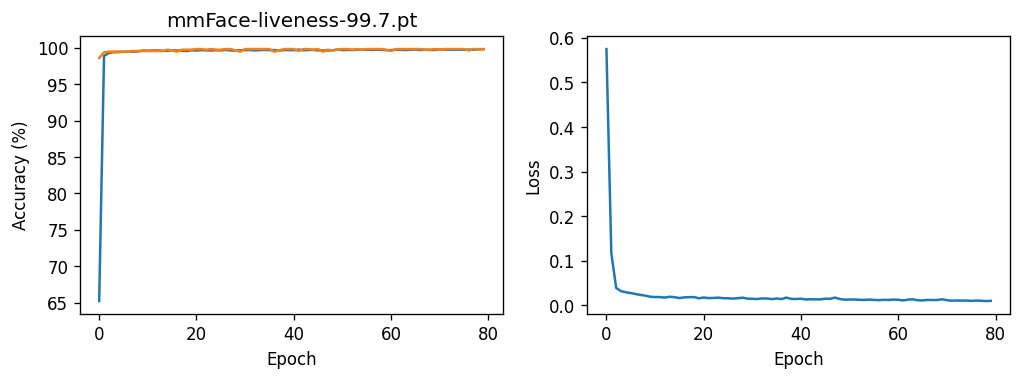

In [40]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

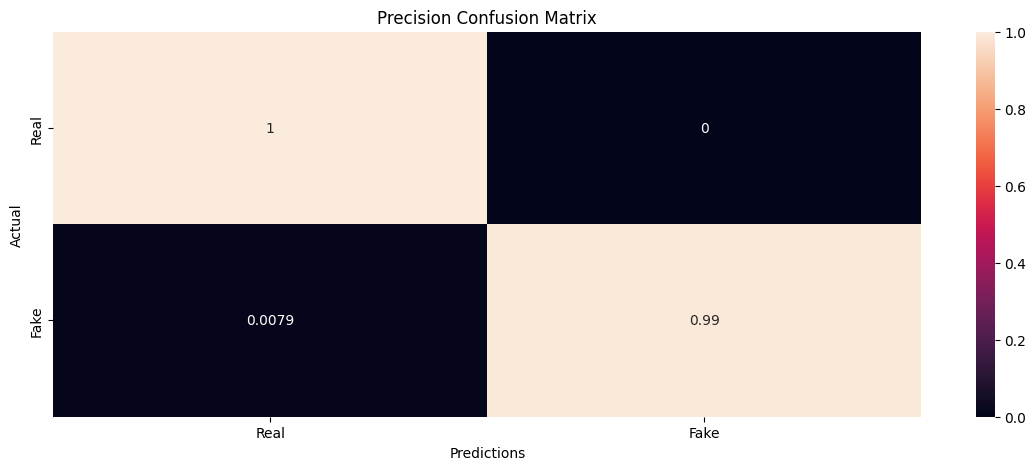

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=["Real", "Fake"], columns=["Real", "Fake"])
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')